In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load Preprocessed Data**

In [2]:
import pandas as pd

train_df = pd.read_csv("/content/drive/MyDrive/property_valuation/data/train_processed.csv")
test_df = pd.read_csv("/content/drive/MyDrive/property_valuation/data/test_processed.csv")


**Import Libraries**

In [3]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

from sklearn.metrics import mean_squared_error, r2_score


**Define Feature Columns**

In [ ]:
TABULAR_FEATURES = ['bedrooms','bathrooms','sqft_living','lat','long']
TARGET = 'price'


**Image Transformation**s

In [ ]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])


**Custom Dataset(Tabular + Iamge)**

In [ ]:
class PropertyDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        tabular = torch.from_numpy(
            row[TABULAR_FEATURES].to_numpy(dtype=np.float32)
        )

        img_path = f"{self.image_dir}/{row['image_id']}.png"

        if os.path.exists(img_path):
            image = Image.open(img_path).convert("RGB")
        else:
            image = Image.new("RGB", (224, 224))

        if self.transform:
            image = self.transform(image)

        y = torch.tensor(row[TARGET], dtype=torch.float32)

        return image, tabular, y


**Datasets & Loaders**

In [ ]:
train_dataset = PropertyDataset(
    train_df, "images", image_transform
)

test_dataset = PropertyDataset(
    test_df, "images", image_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)



In [ ]:
images, tabular, y = next(iter(train_loader))
print(images.shape)


torch.Size([64, 3, 224, 224])


**Mutimodal**

In [ ]:
class MultimodalRegressor(nn.Module):
    def __init__(self):
        super().__init__()

        # CNN backbone
        self.cnn = models.resnet18(pretrained=True)
        self.cnn.fc = nn.Identity()   # output: 512

        # Tabular branch
        self.tabular_fc = nn.Sequential(
            nn.Linear(len(TABULAR_FEATURES), 32),
            nn.ReLU()
        )

        # Fusion head
        self.regressor = nn.Sequential(
            nn.Linear(512 + 32, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, image, tabular):
        img_feat = self.cnn(image)
        tab_feat = self.tabular_fc(tabular)
        fused = torch.cat([img_feat, tab_feat], dim=1)
        return self.regressor(fused).squeeze()


**Move model to GPU**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultimodalRegressor().to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Loss & Optimizer**

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
train_df[TABULAR_FEATURES].dtypes


,0
bedrooms,float64
bathrooms,float64
sqft_living,float64
lat,float64
long,float64


In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "NO GPU")


True
Tesla T4


**Training Loop**

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, tabular, y in train_loader:
        images = images.to(device)
        tabular = tabular.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        preds = model(images, tabular)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} | Train Loss: {total_loss/len(train_loader):.4f}")


Epoch 1 | Train Loss: 0.0818
Epoch 2 | Train Loss: 0.0554
Epoch 3 | Train Loss: 0.0495
Epoch 4 | Train Loss: 0.0479
Epoch 5 | Train Loss: 0.0451


**Evaluation**

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, tabular, y in test_loader:
        images = images.to(device)
        tabular = tabular.to(device)

        preds = model(images, tabular)

        # Always use .cpu() before .numpy()
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Now compute metrics
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

print("Multimodal → RMSE:", rmse)
print("Multimodal → R²:", r2)


Multimodal → RMSE: 0.22734274953229003
Multimodal → R²: 0.6581171478604733


**Tabular Only Baseline**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Prepare data
X_train = train_df[TABULAR_FEATURES].values
y_train = train_df[TARGET].values

X_test = test_df[TABULAR_FEATURES].values
y_test = test_df[TARGET].values

# Train model
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Make predictions
preds_tabular = rf.predict(X_test)


In [ ]:
rmse_tab = np.sqrt(mean_squared_error(y_test, preds_tabular))
r2_tab   = r2_score(y_test, preds_tabular)

print(f"Tabular-Only → RMSE: {rmse_tab:.3f}, R2: {r2_tab:.3f}")


Tabular-Only → RMSE: 0.180, R2: 0.785


**Model Comparison**

In [ ]:
model.eval()
y_true_multi, preds_multi = [], []

with torch.no_grad():
    for images, tabular, y in test_loader:
        images = images.to(device)
        tabular = tabular.to(device)
        y = y.to(device)

        preds = model(images, tabular)

        y_true_multi.extend(y.cpu().numpy())
        preds_multi.extend(preds.cpu().numpy())


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Tabular-only
rmse_tab = np.sqrt(mean_squared_error(y_true_multi, preds_tabular))
r2_tab   = r2_score(y_true_multi, preds_tabular)

# Multimodal
rmse_multi = np.sqrt(mean_squared_error(y_true_multi, preds_multi))
r2_multi   = r2_score(y_true_multi, preds_multi)

print(f"Tabular-Only → RMSE: {rmse_tab:.3f}, R²: {r2_tab:.3f}")
print(f"Multimodal   → RMSE: {rmse_multi:.3f}, R²: {r2_multi:.3f}")


Tabular-Only → RMSE: 0.180, R²: 0.785
Multimodal   → RMSE: 0.227, R²: 0.658


**Save predictions to CSV**

In [ ]:
import pandas as pd

# If targets were scaled by 1e6 in preprocessing, rescale
final_tab_preds   = preds_tabular * 1e6
final_multi_preds = np.array(preds_multi) * 1e6
actual_prices     = np.array(y_true_multi) * 1e6

submission_df = pd.DataFrame({
    "id": test_df.index,
    "actual_price": actual_prices,
    "predicted_price_tabular": final_tab_preds,
    "predicted_price_multimodal": final_multi_preds
})

submission_df.to_csv(
    "/content/drive/MyDrive/property_valuation/data/final_predictions.csv",
    index=False
)


**Grad-CAM for Multimodal CNN**

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
target_layer = model.cnn.layer4[1].conv2  # last conv layer in ResNet branch

In [ ]:
activations = None
gradients = None

def forward_hook(module, input, output):
    global activations
    activations = output

def backward_hook(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

# Register hooks
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

img_path = "/content/drive/MyDrive/property_valuation/images/0.png"
image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)


In [ ]:
# Dummy tabular input for the multimodal model
tab_input = torch.tensor(train_df[TABULAR_FEATURES].iloc[0].values, dtype=torch.float32).unsqueeze(0).to(device)

model.zero_grad()
output = model(input_tensor, tab_input)

# Target is the predicted price
target = output
target.backward()


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [ ]:
# Global average pooling of gradients
weights = torch.mean(gradients, dim=[2,3], keepdim=True)
grad_cam_map = F.relu(torch.sum(weights * activations, dim=1)).squeeze()
grad_cam_map = grad_cam_map.cpu().detach().numpy()

# Normalize
grad_cam_map = (grad_cam_map - grad_cam_map.min()) / (grad_cam_map.max() - grad_cam_map.min())


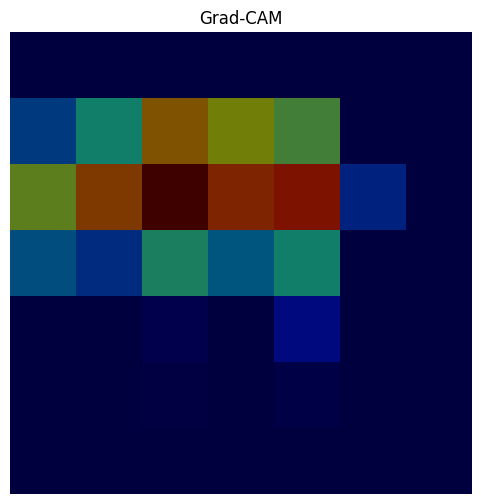

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.imshow(grad_cam_map, cmap='jet', alpha=0.5)  # overlay
plt.axis('off')
plt.title("Grad-CAM")
plt.show()


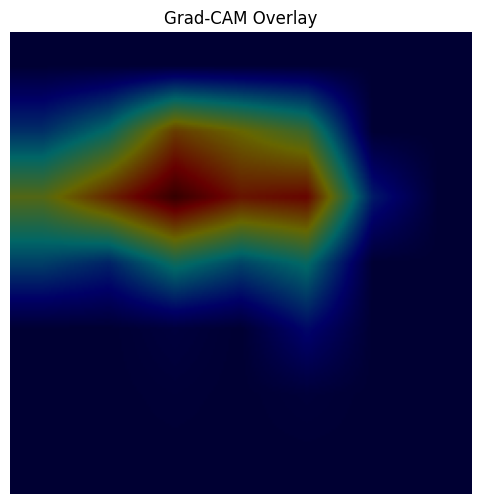

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Assuming `image` is your original PIL image
# and `grad_cam_map` is the 8x8 or 16x16 heatmap from Grad-CAM

# Convert PIL to numpy
image_np = np.array(image)

# Resize Grad-CAM to match image size
grad_cam_map_resized = cv2.resize(grad_cam_map, (image_np.shape[1], image_np.shape[0]))

# Apply colormap
heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map_resized), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Overlay
overlay = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(6,6))
plt.imshow(overlay)
plt.axis('off')
plt.title("Grad-CAM Overlay")
plt.show()


**EDA**

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/property_valuation/kc_house_data.csv")
df.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


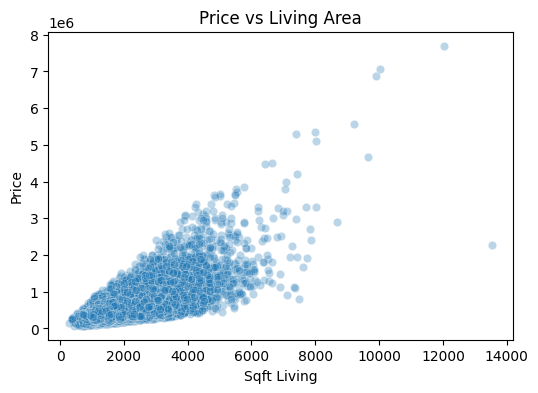

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.scatterplot(
    x=df["sqft_living"],
    y=df["price"],
    alpha=0.3
)
plt.title("Price vs Living Area")
plt.xlabel("Sqft Living")
plt.ylabel("Price")
plt.show()


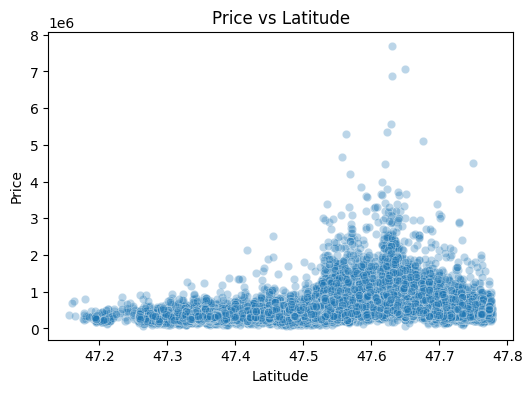

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    x=df["lat"],
    y=df["price"],
    alpha=0.3
)
plt.title("Price vs Latitude")
plt.xlabel("Latitude")
plt.ylabel("Price")
plt.show()


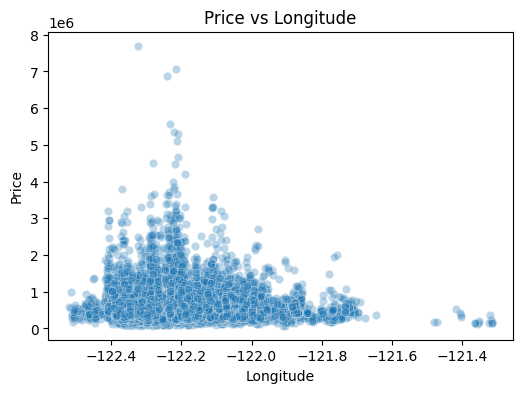

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    x=df["long"],
    y=df["price"],
    alpha=0.3
)
plt.title("Price vs Longitude")
plt.xlabel("Longitude")
plt.ylabel("Price")
plt.show()


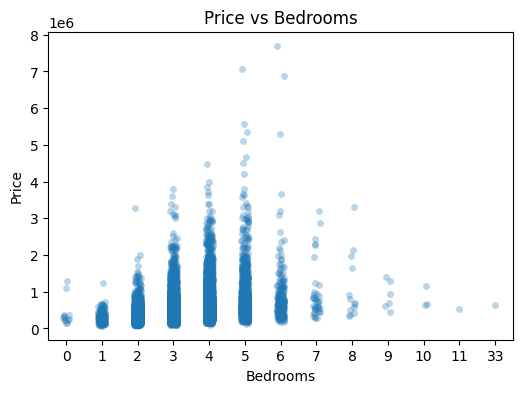

In [ ]:
plt.figure(figsize=(6,4))
sns.stripplot(
    x=df["bedrooms"],
    y=df["price"],
    jitter=True,
    alpha=0.3
)
plt.title("Price vs Bedrooms")
plt.xlabel("Bedrooms")
plt.ylabel("Price")
plt.show()


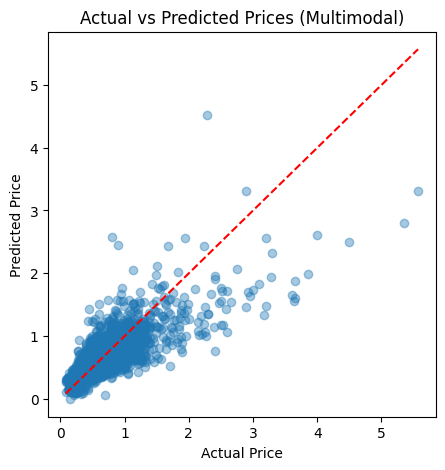

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.plot(
    [min(y_true), max(y_true)],
    [min(y_true), max(y_true)],
    'r--'
)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices (Multimodal)")
plt.show()


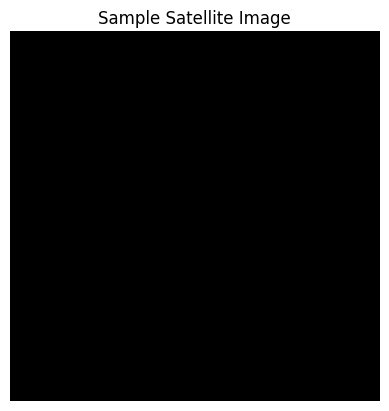

In [ ]:
sample_img = Image.open(
    "/content/drive/MyDrive/property_valuation/images/0.png"
)
plt.imshow(sample_img)
plt.axis("off")
plt.title("Sample Satellite Image")
plt.show()


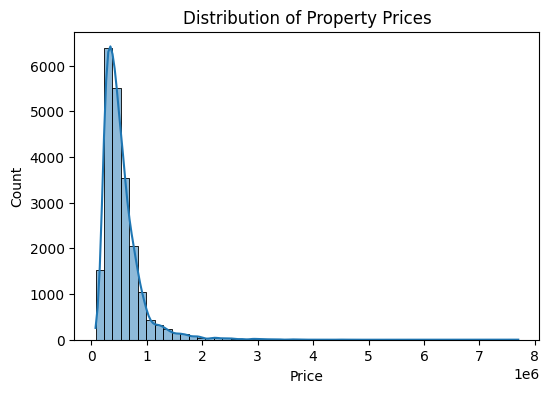

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Distribution of Property Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()


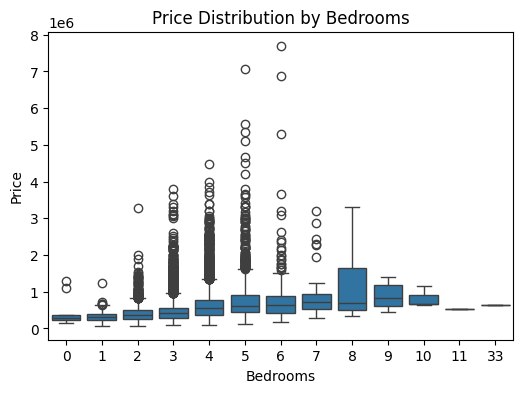

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df["bedrooms"], y=df["price"])
plt.title("Price Distribution by Bedrooms")
plt.xlabel("Bedrooms")
plt.ylabel("Price")
plt.show()


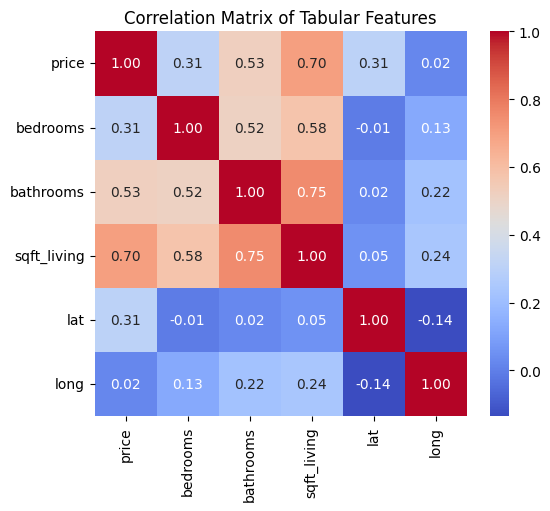

In [ ]:
corr_features = ["price", "bedrooms", "bathrooms", "sqft_living", "lat", "long"]
corr = df[corr_features].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Tabular Features")
plt.show()


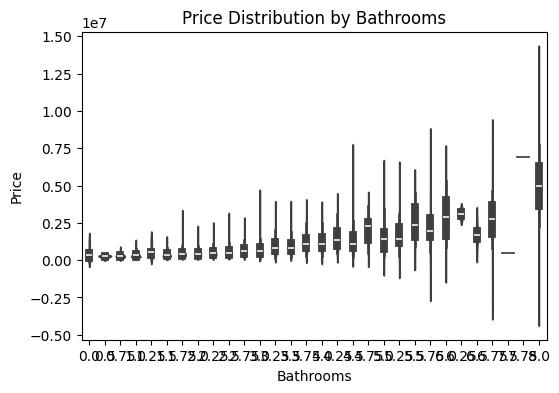

In [ ]:
plt.figure(figsize=(6,4))
sns.violinplot(x=df["bathrooms"], y=df["price"])
plt.title("Price Distribution by Bathrooms")
plt.xlabel("Bathrooms")
plt.ylabel("Price")
plt.show()


**XG Boost Baseline (Tabular Only)**

In [4]:
# Install xgboost (run once)
!pip install xgboost


In [5]:
import pandas as pd
import numpy as np

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [6]:
train_df = pd.read_csv("/content/drive/MyDrive/property_valuation/data/train_processed.csv")
test_df  = pd.read_csv("/content/drive/MyDrive/property_valuation/data/test_processed.csv")

FEATURES = ['bedrooms','bathrooms','sqft_living','lat','long']
TARGET = 'price'

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_test  = test_df[FEATURES]
y_test  = test_df[TARGET]


In [7]:
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [8]:
preds_xgb = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, preds_xgb))
r2_xgb   = r2_score(y_test, preds_xgb)

rmse_xgb, r2_xgb


(np.float64(0.17258596595141162), 0.8029728574016473)